Copyright (c) 2018 SumUp Analytics, Inc. All Rights Reserved.

NOTICE: All information contained herein is, and remains the property of SumUp Analytics Inc. and its suppliers, if any. The intellectual and technical concepts contained herein are proprietary to SumUp Analytics Inc. and its suppliers and may be covered by U.S. and Foreign Patents, patents in process, and are protected by trade secret or copyright law.

Dissemination of this information or reproduction of this material is strictly forbidden unless prior written permission is obtained from SumUp Analytics Inc.

# Initialization, configure API host and key, and create new API instance

In [10]:
import os
import csv
import json
import datetime
import time
import nucleus_api
from nucleus_api.rest import ApiException
from nucleus_api.api.nucleus_api import topic_charts_historical,summarize_file_url
from pprint import pprint
import numpy as np

# Determine if in Jupyter notebook or not
try:
    ip = get_ipython()
    running_notebook = True
except NameError:
    running_notebook = False

if running_notebook:
    print('Running example in Jupyter Notebook')
else:
    print('Running example in script mode')
    
configuration = nucleus_api.Configuration()
configuration.host = 'UPDATE-WITH-API-SERVER-HOSTNAME'
configuration.api_key['x-api-key'] = 'UPDATE-WITH-API-KEY'

# Create API instance
api_instance = nucleus_api.NucleusApi(nucleus_api.ApiClient(configuration))

Running example in Jupyter Notebook


# Dataset APIs

## Append file from local drive to dataset

In [11]:
print('--------- Append file from local drive to dataset -----------')
file = 'quarles20181109a.pdf'         # file | 
dataset = 'dataset_test'              # str | Destination dataset where the file will be inserted.
metadata = {"time": "1/2/2018", 
            "author": "Test Author"}  # Optional json containing additional document metadata

try:
    api_response = api_instance.post_upload_file(file, dataset, metadata=metadata)
    print(api_response.result, 'has been added to dataset', dataset)
    #print('api_response=', api_response)   # raw API response    
except ApiException as e:
    print("Exception when calling DatasetsApi->post_upload_file: %s\n" % e)

print('-------------------------------------------------------------')

--------- Append file from local drive to dataset -----------
Exception when calling DatasetsApi->post_upload_file: (401)
Reason: UNAUTHORIZED
HTTP response headers: HTTPHeaderDict({'Server': 'gunicorn/19.9.0', 'Date': 'Fri, 08 Feb 2019 07:00:05 GMT', 'Connection': 'close', 'Content-Type': 'application/json', 'Content-Length': '94'})
HTTP response body: {"message": "API key expired. Please contact SumUp technical support to renew your API key."}



-------------------------------------------------------------


# Append all files from local folder to dataset

In [3]:
print('--------- Append all files from local folder to dataset -----------')
folder = 'fomc-minutes'         

dataset = 'dataset_test'              # str | Destination dataset where the file will be inserted.
metadata = {"time": "1/2/2018", 
            "author": "Test Author"}  # Optional json containing additional document metadata

for root, dirs, files in os.walk(folder):
    for file in files:
        file = os.path.join(root, file)
        
        try:
            api_response = api_instance.post_upload_file(file, dataset, metadata=metadata)
            #print('api_response=', api_response)   # raw API response    
        except ApiException as e:
            print("Exception when calling DatasetsApi->post_upload_file: %s\n" % e)
            exit


        print(api_response.result, 'has been added to dataset', dataset)

print('-------------------------------------------------------------')

--------- Append all files from local folder to dataset -----------
fomcminutes20181219.pdf has been added to dataset dataset_test
fomcminutes20181108.pdf has been added to dataset dataset_test
-------------------------------------------------------------


## Append file from URL to dataset

In [4]:
print('------------ Append file from URL to dataset ---------------')

dataset = 'dataset_test'
file_url = 'https://s3-us-west-2.amazonaws.com/sumup-public/nucleus-sdk/quarles20181109a.docx'
# Optional filename saved on the server for the URL. If not specified, Nucleus will make
# an intelligent guess from the file URL
filename = 'quarles20181109a-newname.pdf'  
payload = nucleus_api.UploadURLModel(
                dataset=dataset,
                file_url=file_url,
                filename=filename  
            ) # UploadURLModel | 

try:
    api_response = api_instance.post_upload_url(payload)
    #print('api_response=', api_response)   # raw API response
except ApiException as e:
    print("Exception when calling DatasetsApi->post_upload_url: %s\n" % e)
    
print(api_response.result, 'has been added to dataset', dataset)
print('-------------------------------------------------------------')

------------ Append file from URL to dataset ---------------
https://s3-us-west-2.amazonaws.com/sumup-public/nucleus-sdk/quarles20181109a.docx has been added to dataset dataset_test
-------------------------------------------------------------


## Append json from csv to dataset

In [5]:
# This dataset will be used to test all topics and documents APIs
print('----------- Append json from CSV to dataset -----------------')
csv_file = 'trump-tweets-100.csv'
dataset = 'trump-tweets'  

with open(csv_file, encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    doc_count = 0
    for row in reader:
        payload = nucleus_api.Appendjsonparams(dataset=dataset, 
                                               #language='english', #optional. language can be auto detected
                                               document={'time'   : row['time'],
                                                         'title'  : row['title'],
                                                         'content': row['content'],
                                                         'author' : row['author']}
                                              )

        try:
            api_response = api_instance.post_append_json_to_dataset(payload)
            #print('api_response', api_response)
        except ApiException as e:
            print("Exception when calling DatasetsApi->post_append_json_to_dataset: %s\n" % e)
            
        doc_count += 1
        
print(doc_count, 'documents added to dataset', dataset)
print('-------------------------------------------------------------')

----------- Append json from CSV to dataset -----------------
100 documents added to dataset trump-tweets
-------------------------------------------------------------


## List available datasets

In [6]:
print('---------------- List available datasets ---------------------')
try:
    api_response = api_instance.get_list_datasets()
except ApiException as e:
    print("Exception when calling DatasetsApi->get_list_datasets: %s\n" % e)

list_datasets = api_response.result

print(len(list_datasets), 'datasets in the database:')
for ds in list_datasets:
    print('    ', ds)

    
print('-------------------------------------------------------------')

---------------- List available datasets ---------------------
3 datasets in the database:
     dataset_test
     trump_tweets
     trump_tweets_full
-------------------------------------------------------------


## Get dataset information

In [7]:
print('--------------- Get dataset information -------------------')
dataset = 'dataset_test' # str | Dataset name.
query = '' # str | Fulltext query, using mysql MATCH boolean query format. (optional)
metadata_selection = '' # str | json object of {\"metadata_field\":[\"selected_values\"]} (optional)
time_period = '' # str | Time period selection (optional)
period_start = "" # str | Start date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"
period_end = "" # str | End date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"

try:
    payload = nucleus_api.DatasetInfo(dataset=dataset, 
                                    query=query, 
                                    metadata_selection=metadata_selection, 
                                    time_period=time_period)
    api_response = api_instance.post_dataset_info(payload)
    #print('api_response=', api_response) # raw API response
except ApiException as e:
    print("Exception when calling DatasetsApi->post_dataset_info: %s\n" % e)

print('Information about dataset', dataset)
print('    Language:', api_response.result.detected_language)
print('    Number of documents:', api_response.result.num_documents)
print('    Time range:', datetime.datetime.fromtimestamp(float(api_response.result.time_range[0])),
             'to', datetime.datetime.fromtimestamp(float(api_response.result.time_range[1])))


print('-------------------------------------------------------------')

--------------- Get dataset information -------------------
Information about dataset dataset_test
    Language: en
    Number of documents: 4
    Time range: 2018-01-02 00:00:00 to 2019-02-07 00:34:58
-------------------------------------------------------------


## Delete document

In [8]:
print('--------------------- Delete document -----------------------')
dataset = 'dataset_test'
docid = '1'
payload = nucleus_api.Deletedocumentmodel(dataset=dataset,
                                             docid=docid) # Deletedocumentmodel | 

try:
    api_response = api_instance.post_delete_document(payload)
except ApiException as e:
    print("Exception when calling DatasetsApi->post_delete_document: %s\n" % e)


print('Document', docid, 'from dataset', dataset, 'has been deleted.')
# print(api_response)     # raw API response
print('-------------------------------------------------------------')

--------------------- Delete document -----------------------
Document 1 from dataset dataset_test has been deleted.
-------------------------------------------------------------


## Delete dataset

In [9]:
print('--------------------- Delete dataset ------------------------')

dataset = 'dataset_test'  
payload = nucleus_api.Deletedatasetmodel(dataset=dataset) # Deletedatasetmodel | 

try:
    api_response = api_instance.post_delete_dataset(payload)
    #print(api_response)
except ApiException as e:
    print("Exception when calling DatasetsApi->post_delete_dataset: %s\n" % e)
    
# List datasets again to check if the specified dataset has been deleted
try:
    api_response = api_instance.get_list_datasets()
    #print('api_response=', api_response)
except ApiException as e:
    print("Exception when calling DatasetsApi->get_list_datasets: %s\n" % e)
    
print('-------------------------------------------------------------')

--------------------- Delete dataset ------------------------
-------------------------------------------------------------


# Topic APIs

## Get list of topics from dataset

In [10]:
print('------------- Get list of topics from dataset --------------')
dataset = 'trump_tweets'
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
metadata_selection = "" # dict | JSON object specifying metadata-based queries on the dataset, of type {"metadata_field": "selected_values"} (optional)
time_period = ""     # str | Time period selection. Choices: ["1M","3M","6M","12M","3Y","5Y",""] (optional)

try:
    payload = nucleus_api.Topics(dataset=dataset,                                
                                query=query,                   
                                custom_stop_words=custom_stop_words,     
                                num_topics=num_topics,
                                metadata_selection=metadata_selection,
                                time_period=time_period)
    api_response = api_instance.post_topic_api(payload)        
except ApiException as e:
    print("Exception when calling TopicsApi->post_topic_api: %s\n" % e)
    
#print(api_response)
i = 1
for res in api_response.result:
    print('Topic', i, 'keywords:')
    print('    Keywords:', res.topic)
    keywords_weight_str = ";".join(str(x) for x in res.keywords_weight)
    print('    Keyword weights:', keywords_weight_str)
    print('    Strength:', res.strength)
    doc_topic_exposure_sel = []  # list of non-zero doc_topic_exposure
    doc_id_sel = []        # list of doc ids matching doc_topic_exposure_sel
    for j in range(len(res.doc_topic_exposure)):
        doc_topic_exp = float(res.doc_topic_exposure[j])
        if doc_topic_exp != 0:
            doc_topic_exposure_sel.append(doc_topic_exp)
            doc_id_sel.append(res.doc_id[j])
    
    doc_id_sel_str = ' '.join(str(x) for x in doc_id_sel)
    doc_topic_exposure_sel_str = ' '.join(str(x) for x in doc_topic_exposure_sel)
    print('    Document IDs:', doc_id_sel_str)
    print('    Document exposures:', doc_topic_exposure_sel_str)

    print('---------------')
    i = i + 1
    
print('-------------------------------------------------------------')

------------- Get list of topics from dataset --------------
Topic 1 keywords:
    Keywords: illegal aliens;united permission;permission illegal;enter united;aliens treated;aliens illegal;legally chuck;chuck schumer
    Keyword weights: 0.06550428489458975;0.12414163288726007;0.12414163288726007;0.12414163288726007;0.24828326577452015;0.12414163288726007;0.12414163288726007;0.06550428489458975
    Strength: 0.14746931502685073
    Document IDs: 57 63 3657 3663
    Document exposures: 0.24447581722447137 0.24447581722447137 0.25552418277552863 0.25552418277552863
---------------
Topic 2 keywords:
    Keywords: bruce ohr;christopher steele;ohr justice;justice department;wife nelly;fusion gps;ohr wrote;learned bruce
    Keyword weights: 0.25159281622394286;0.06800868168815107;0.06800868168815107;0.13346810589750308;0.12890015838310886;0.12890015838310886;0.11056069886801712;0.11056069886801712
    Strength: 0.18733827269816053
    Document IDs: 11 12 13 31 33 70 3613 3633 3670 5213 5231
 

## Get list of topics from dataset with a time range selection

In [11]:
print('------------- Get list of topics from dataset --------------')
dataset = 'trump_tweets'
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
metadata_selection = "" # dict | JSON object specifying metadata-based queries on the dataset, of type {"metadata_field": "selected_values"} (optional)
period_start = "2016-10-15 04:30:00" # str | Start date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"
period_end = "2019-01-01 12:00:05" # str | End date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"

try:
    payload = nucleus_api.Topics(dataset=dataset,                                
                                query=query,                   
                                custom_stop_words=custom_stop_words,     
                                num_topics=num_topics,
                                metadata_selection=metadata_selection,
                                period_start=period_start,
                                period_end=period_end)
    api_response = api_instance.post_topic_api(payload)        
except ApiException as e:
    print("Exception when calling TopicsApi->post_topic_api: %s\n" % e)
    
#print(api_response)
i = 1
for res in api_response.result:
    print('Topic', i, 'keywords:')
    print('    Keywords:', res.topic)
    keywords_weight_str = ";".join(str(x) for x in res.keywords_weight)
    print('    Keyword weights:', keywords_weight_str)
    print('    Strength:', res.strength)
    doc_topic_exposure_sel = []  # list of non-zero doc_topic_exposure
    doc_id_sel = []        # list of doc ids matching doc_topic_exposure_sel
    for j in range(len(res.doc_topic_exposure)):
        doc_topic_exp = float(res.doc_topic_exposure[j])
        if doc_topic_exp != 0:
            doc_topic_exposure_sel.append(doc_topic_exp)
            doc_id_sel.append(res.doc_id[j])
    
    doc_id_sel_str = ' '.join(str(x) for x in doc_id_sel)
    doc_topic_exposure_sel_str = ' '.join(str(x) for x in doc_topic_exposure_sel)
    print('    Document IDs:', doc_id_sel_str)
    print('    Document exposures:', doc_topic_exposure_sel_str)

    print('---------------')
    i = i + 1
    
print('-------------------------------------------------------------')

------------- Get list of topics from dataset --------------
Topic 1 keywords:
    Keywords: total endorsement;complete total;pete complete;bob total;america great;andrew cuomo;great great;statement america
    Keyword weights: 0.002303655647737967;0.0019018054033688545;0.002893921286722606;0.002227083939682826;0.414573881186317;0.47968756550966934;0.033660404353146725;0.06275168267335474
    Strength: 0.2872023902295528
    Document IDs: 16 17 18 19 24 44 45 54 55 56 58 59 61 62 80 83 116 117 118 119 124 144 145 154 155 156 158 159 161 162 180 183 216 217 218 219 224 244 245 254 255 256 258 259 261 262 280 283 316 317 318 319 324 344 345 354 355 356 358 359 361 362 380 383 416 417 418 419 424 444 445 454 455 456 458 459 461 462 480 483 516 517 518 519 524 544 545 554 555 556 558 559 561 562 580 583 616 617 618 619 624 644 645 654 655 656 658 659 661 662 680 683 716 717 718 719 724 744 745 754 755 756 758 759 761 762 780 783 816 817 818 819 824 844 845 854 855 856 858 859 861 862 880 8

## Get list of topics from dataset with a metadata selection

In [12]:
print('------------- Get list of topics from dataset --------------')
dataset = 'trump_tweets'
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
metadata_selection = {"author": "D_Trump16"} # dict | JSON object specifying metadata-based queries on the dataset, of type {"metadata_field": "selected_values"} (optional)

try:
    payload = nucleus_api.Topics(dataset=dataset,                                
                                query=query,                   
                                custom_stop_words=custom_stop_words,     
                                num_topics=num_topics,
                                metadata_selection=metadata_selection)
    api_response = api_instance.post_topic_api(payload)        
except ApiException as e:
    print("Exception when calling TopicsApi->post_topic_api: %s\n" % e)
    
#print(api_response)
i = 1
for res in api_response.result:
    print('Topic', i, 'keywords:')
    print('    Keywords:', res.topic)
    keywords_weight_str = ";".join(str(x) for x in res.keywords_weight)
    print('    Keyword weights:', keywords_weight_str)
    print('    Strength:', res.strength)
    doc_topic_exposure_sel = []  # list of non-zero doc_topic_exposure
    doc_id_sel = []        # list of doc ids matching doc_topic_exposure_sel
    for j in range(len(res.doc_topic_exposure)):
        doc_topic_exp = float(res.doc_topic_exposure[j])
        if doc_topic_exp != 0:
            doc_topic_exposure_sel.append(doc_topic_exp)
            doc_id_sel.append(res.doc_id[j])
    
    doc_id_sel_str = ' '.join(str(x) for x in doc_id_sel)
    doc_topic_exposure_sel_str = ' '.join(str(x) for x in doc_topic_exposure_sel)
    print('    Document IDs:', doc_id_sel_str)
    print('    Document exposures:', doc_topic_exposure_sel_str)

    print('---------------')
    i = i + 1
    
print('-------------------------------------------------------------')

------------- Get list of topics from dataset --------------
Topic 1 keywords:
    Keywords: worse hightax;hightax andrew;andrew cuomo
    Keyword weights: 0.3333333333333333;0.3333333333333333;0.3333333333333333
    Strength: 0.3333333333333333
    Document IDs: 16
    Document exposures: 1.0
---------------
Topic 2 keywords:
    Keywords: statement america;cuomo statement;america great
    Keyword weights: 0.3333333333333333;0.3333333333333333;0.3333333333333333
    Strength: 0.3333333333333333
    Document IDs: 16
    Document exposures: 1.0
---------------
Topic 3 keywords:
    Keywords: hillary clinton;great hillary;great great
    Keyword weights: 0.3333333333333333;0.3333333333333333;0.3333333333333333
    Strength: 0.3333333333333333
    Document IDs: 16
    Document exposures: 1.0
---------------
-------------------------------------------------------------


## Get topic summary

In [13]:
print('------------------- Get topic summary -----------------------')
dataset = 'trump_tweets' # str | Dataset name.
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
summary_length = 6 # int | The maximum number of bullet points a user wants to see in each topic summary. (optional) (default to 6)
context_amount = 0 # int | The number of sentences surrounding key summary sentences in the documents that they come from. (optional) (default to 0)
num_docs = 20 # int | The maximum number of key documents to use for summarization. (optional) (default to 20)
excluded_docs = '' # str | List of document IDs that should be excluded from the analysis. Example, ["docid1", "docid2", ..., "docidN"]  (optional)

metadata_selection ="" # dict | JSON object specifying metadata-based queries on the dataset, of type {"metadata_field": "selected_values"} (optional)
time_period = ""     # str | Time period selection. Choices: ["1M","3M","6M","12M","3Y","5Y",""]  (optional)
period_start = "" # str | Start date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"
period_end = "" # str | End date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"

try:
    payload = nucleus_api.Summary(dataset=dataset, 
                                    query=query, 
                                    custom_stop_words=custom_stop_words, 
                                    num_topics=num_topics, 
                                    num_keywords=num_keywords,
                                    metadata_selection=metadata_selection,
                                    summary_length=summary_length, 
                                    context_amount=context_amount, 
                                    num_docs=num_docs)
    api_response = api_instance.post_topic_summary_api(payload)        
except ApiException as e:
    print("Exception when calling TopicsApi->post_topic_summary_api: %s\n" % e)

i = 1
for res in api_response.result:
    print('Topic', i, 'summary:')
    print('    Keywords:', res.topic)
    for j in range(len(res.summary)):
        print(res.summary[j])
        print('    Document ID:', res.summary[j].sourceid)
        print('        Title:', res.summary[j].title)
        print('        Sentences:', res.summary[j].sentences)
        print('        Author:', res.summary[j].attribute['author'])
        print('        Time:', datetime.datetime.fromtimestamp(float(res.summary[j].attribute['time'])))
        
    print('---------------')
    i = i + 1
    
    
#pprint(api_response)  # raw API response
print('-------------------------------------------------------------')

------------------- Get topic summary -----------------------
Topic 1 summary:
    Keywords: illegal aliens;united permission;permission illegal;enter united;aliens treated;aliens illegal;legally chuck;chuck schumer
{'attribute': {'author': 'D_Trump57',
               'counts': None,
               'source': None,
               'time': 1534339080},
 'sentences': "['“People who enter the United States without our permission "
              'are illegal aliens and illegal aliens should not be treated the '
              'same as people who entered the U.S. legally.” Chuck Schumer in '
              "2009 before he went left and haywire!']",
 'sourceid': '57',
 'title': 'D_Trump2018_8_15_13_18'}
    Document ID: 57
        Title: D_Trump2018_8_15_13_18
        Sentences: ['“People who enter the United States without our permission are illegal aliens and illegal aliens should not be treated the same as people who entered the U.S. legally.” Chuck Schumer in 2009 before he went left and hay

## Get topic sentiment

In [14]:
print('---------------- Get topic sentiment ------------------------')
dataset = 'trump_tweets' # str | Dataset name.
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
excluded_docs = '' # str | List of document IDs that should be excluded from the analysis. Example, ["docid1", "docid2", ..., "docidN"]  (optional)
custom_dict_file = {"great": 1.0, "awful": -1.0, "clinton":-1.0, "trump":1.0} # file | Custom sentiment dictionary JSON file. Example, {"field1": value1, ..., "fieldN": valueN} (optional)

metadata_selection ="" # dict | JSON object specifying metadata-based queries on the dataset, of type {"metadata_field": "selected_values"} (optional)
time_period = ""     # str | Time period selection. Choices: ["1M","3M","6M","12M","3Y","5Y",""] (optional)
period_start = "" # str | Start date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"
period_end = "" # str | End date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"

try:
    payload = nucleus_api.Sentiment(dataset=dataset, 
                                    query=query, 
                                    custom_stop_words=custom_stop_words, 
                                    num_topics=num_topics, 
                                    num_keywords=num_keywords,
                                    custom_dict_file=custom_dict_file)
    api_response = api_instance.post_topic_sentiment_api(payload)
    
except ApiException as e:
    print("Exception when calling TopicsApi->post_topic_sentiment_api: %s\n" % e)

i = 1
for res in api_response.result:
    print('Topic', i, 'sentiment:')
    print('    Keywords:', res.topic)
    print('    Sentiment:', res.sentiment)
    print('    Strength:', res.strength)
    
    doc_id_str = ' '.join(str(x) for x in res.doc_id)
    doc_sentiment_str = ' '.join(str(x) for x in res.doc_sentiment)
    doc_score_str = ' '.join(str(x) for x in res.doc_score)
    print('    Document IDs:', doc_id_str)
    print('    Document Sentiments:', doc_sentiment_str)
    print('    Document Scores:', doc_score_str)
    
    print('---------------')
    i = i + 1
    
#pprint(api_response)
print('-------------------------------------------------------------')

---------------- Get topic sentiment ------------------------
Topic 1 sentiment:
    Keywords: illegal aliens;united permission;permission illegal;enter united;aliens treated;aliens illegal;legally chuck;chuck schumer
    Sentiment: 0.0
    Strength: 0.14746931502685073
    Document IDs: 57 63 3657 3663
    Document Sentiments: 0.0 0.0 0.0 0.0
    Document Scores: [0.24447581722447131, 0.24447581722447131, 0.2555241827755287, 0.2555241827755287]
---------------
Topic 2 sentiment:
    Keywords: bruce ohr;christopher steele;ohr justice;justice department;wife nelly;fusion gps;ohr wrote;learned bruce
    Sentiment: 0.028950645690777363
    Strength: 0.18733827269816053
    Document IDs: 11 12 13 31 33 70 3613 3633 3670 5213 5231
    Document Sentiments: 0.0 0.0 0.0 0.125 0.0 0.10526315789473684 0.0 0.0 0.05555555555555555 0.0 0.0
    Document Scores: [0.0632637104057317, 0.0632637104057317, 0.07176621238859042, 0.07305064046536745, 0.11248663261030929, 0.12208442511057296, 0.0802370646942

## Get topic consensus

In [15]:
print('---------------- Get topic consensus ------------------------')
dataset = 'trump_tweets' # str | Dataset name.
query = '' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
excluded_docs = [''] # str | List of document IDs that should be excluded from the analysis. Example, ["docid1", "docid2", ..., "docidN"]  (optional)
custom_dict_file = {"great": 1.0, "awful": -1.0, "clinton":-1.0, "trump":1.0} # file | Custom sentiment dictionary JSON file. Example, {"field1": value1, ..., "fieldN": valueN} (optional)

metadata_selection ="" # dict | JSON object specifying metadata-based queries on the dataset, of type {"metadata_field": "selected_values"} (optional)
time_period = ""     # str | Time period selection. Choices: ["1M","3M","6M","12M","3Y","5Y",""] (optional)
period_start = "" # str | Start date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"
period_end = "" # str | End date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"

try:
    payload = nucleus_api.Consensus(dataset=dataset, 
                                    query=query, 
                                    custom_stop_words=custom_stop_words, 
                                    num_topics=num_topics, 
                                    num_keywords=num_keywords,
                                    custom_dict_file=custom_dict_file)
    api_response = api_instance.post_topic_consensus_api(payload)
except ApiException as e:
    print("Exception when calling TopicsApi->post_topic_consensus_api: %s\n" % e)
    
i = 1
for res in api_response.result:
    print('Topic', i, 'consensus:')
    print('    Keywords:', res.topic)
    print('    Consensus:', res.consensus)
    print('    Strength:', res.strength)
    
    print('---------------')
    i = i + 1
    
#pprint(api_response) # raw API response
print('-------------------------------------------------------------')

---------------- Get topic consensus ------------------------
Topic 1 consensus:
    Keywords: illegal aliens;united permission;permission illegal;enter united;aliens treated;aliens illegal;legally chuck;chuck schumer
    Consensus: 1.0
    Strength: 0.14746931502685073
---------------
Topic 2 consensus:
    Keywords: bruce ohr;christopher steele;ohr justice;justice department;wife nelly;fusion gps;ohr wrote;learned bruce
    Consensus: 0.6794351111413874
    Strength: 0.18733827269816053
---------------
Topic 3 consensus:
    Keywords: andrew cuomo;total meltdown;taxed andrew;highest taxed;governor highest;cuomo total;believe governor;america great
    Consensus: 0.7012252648980186
    Strength: 0.12694605613266136
---------------
Topic 4 consensus:
    Keywords: trump campaign;lou dobbs;evidence collusion;democrats evidence;conflicts angry;collusion trump;campaign russia;angry democrats
    Consensus: 1.0
    Strength: 0.13292050611526784
---------------
Topic 5 consensus:
    Keywor

## Get topic historical analysis

------------ Get topic historical analysis ----------------
Plotting historical metrics data...


/Users/jimw/venv/py3-api/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/jimw/github/sumup/nucleus-api/nucleus/rest_api/swagger/python/python-api/nucleus_api/api/nucleus_api.py:130: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.0, top=0.0
  current_axSent.set_ylim([-1.05*current_max_sent, 1.05*current_max_sent])


-------------------------------------------------------------


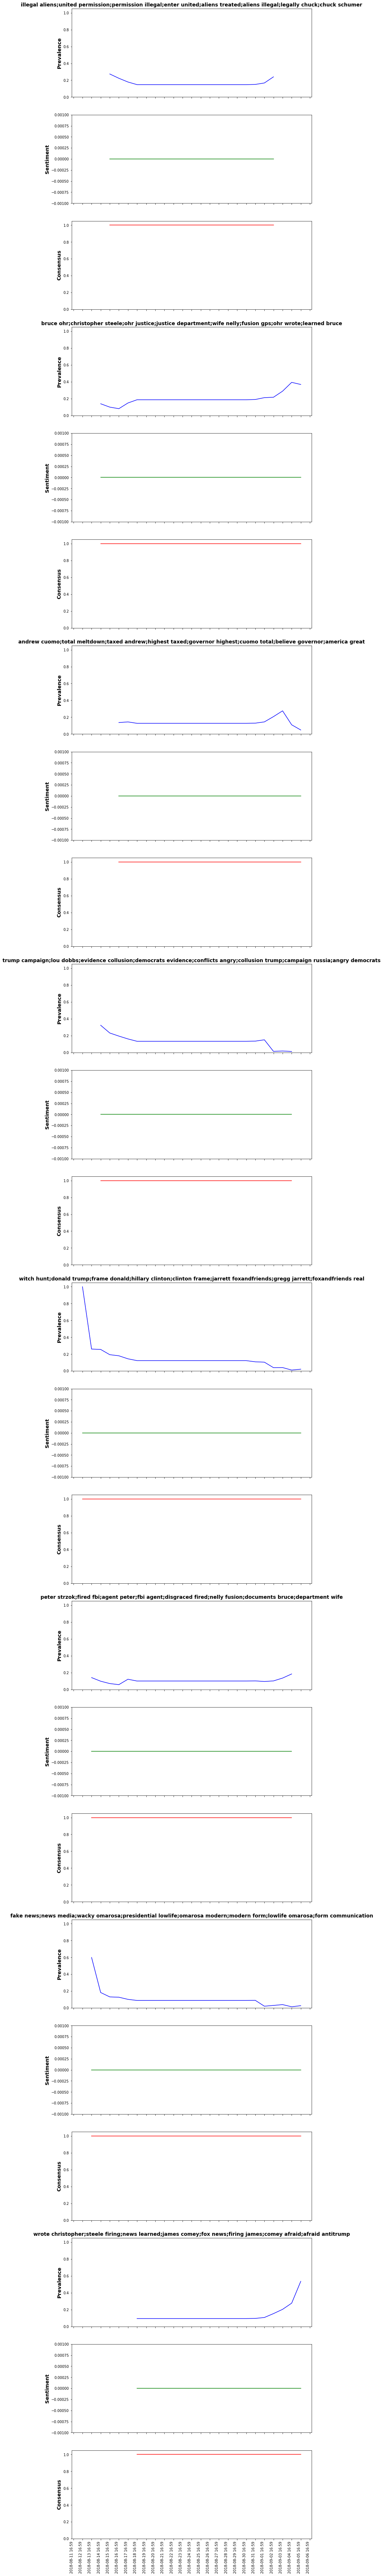

In [16]:
print('------------ Get topic historical analysis ----------------')

dataset = 'trump_tweets'   # str | Dataset name.
update_period = 'd' # str | Frequency at which the historical anlaysis is performed. choices=["d","m","H","M"] (default to d)
query = '' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
custom_stop_words = ["real","hillary"] # str | List of stop words (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
inc_step = 1 # int | Number of increments of the udpate period in between two historical computations. (optional) (default to 1)
excluded_docs = [''] # str | List of document IDs that should be excluded from the analysis. Example, ["docid1", "docid2", ..., "docidN"]  (optional)
custom_dict_file = {} # file | Custom sentiment dictionary JSON file. Example, {"field1": value1, ..., "fieldN": valueN} (optional)

metadata_selection ="" # dict | JSON object specifying metadata-based queries on the dataset, of type {"metadata_field": "selected_values"} (optional)
time_period = "6M"     # str | Time period selection. Choices: ["1M","3M","6M","12M","3Y","5Y",""] (optional)
period_start = "" # str | Start date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"
period_end = "" # str | End date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"

try:
    payload = nucleus_api.TopicHistoryModel(
        dataset=dataset, 
        time_period=time_period, 
        update_period=update_period, 
        query=query, 
        custom_stop_words=custom_stop_words, 
        num_topics=num_topics, 
        num_keywords=num_keywords, 
        metadata_selection=metadata_selection, 
        inc_step=inc_step, 
        excluded_docs=excluded_docs,
        custom_dict_file=custom_dict_file)
    api_response = api_instance.post_topic_historical_analysis_api(payload)
except ApiException as e:
    print("Exception when calling TopicsApi->post_topic_historical_analysis_api: %s\n" % e)

#print('api_response=', api_response)
results = api_response.result

# chart the historical metrics when running in Jupyter Notebook
if running_notebook:
    print('Plotting historical metrics data...')
    historical_metrics = []
    for res in results:
        # conctruct a list of historical metrics dictionaries for charting
        historical_metrics.append({
            'topic'    : res.topic,
            'time_stamps' : np.array(res.time_stamps),
            'strength' : np.array(res.strength, dtype=np.float32),
            'consensus': np.array(res.consensus, dtype=np.float32), 
            'sentiment': np.array(res.sentiment, dtype=np.float32)})

    selected_topics = range(len(historical_metrics)) 
    topic_charts_historical(historical_metrics, selected_topics, True)
else:
    print('Printing historical metrics data...')
    print('NOTE: historical metrics data can be plotted when running the example in Jupyter Notebook')
    i = 1
    for res in results:
        print('Topic', i, res.topic)
        print('    Timestamps:', res.time_stamps)
        print('    Strength:', res.strength)
        print('    Consensus:', res.consensus)
        print('    Sentiment:', res.sentiment)
        print('----------------')
        i = i + 1
#pprint(api_response)
print('-------------------------------------------------------------')

## Get author connectivity

In [17]:
print('----------------- Get author connectivity -------------------')
dataset = dataset # str | Dataset name.
target_author = 'D_Trump16' # str | Name of the author to be analyzed.
query = '' # str | Fulltext query, using mysql MATCH boolean query format. Subject covered by the author, on which to focus the analysis of connectivity. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
custom_stop_words = ["real","hillary"] # str | List of words possibly used by the target author that are considered not information-bearing. (optional)
excluded_docs = [''] # str | List of document IDs that should be excluded from the analysis. Example, ["docid1", "docid2", ..., "docidN"]  (optional)

metadata_selection ="" # dict | JSON object specifying metadata-based queries on the dataset, of type {"metadata_field": "selected_values"} (optional)
time_period = "12M"     # str | Time period selection. Choices: ["1M","3M","6M","12M","3Y","5Y",""] (optional)
period_start = "" # str | Start date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"
period_end = "" # str | End date for the period to analyze within the dataset. Format: "YYYY-MM-DD HH:MM:SS"

try:
    payload = nucleus_api.AuthorConnection(dataset=dataset, 
                                            target_author=target_author, 
                                            query=query, 
                                            custom_stop_words=custom_stop_words, 
                                            time_period=time_period, 
                                            metadata_selection=metadata_selection, 
                                            excluded_docs=excluded_docs)
    api_response = api_instance.post_author_connectivity_api(payload)    
except ApiException as e:
    print("Exception when calling TopicsApi->post_author_connectivity_api: %s\n" % e)

res = api_response.result
print('Mainstream connections:')
for mc in res.mainstream_connection:
    print('    Topic:', mc.topic)
    print('    Authors:', " ".join(str(x) for x in mc.authors))
    
print('Niche connections:')
for nc in res.niche_connection:
    print('    Topic:', nc.topic)
    print('    Authors:', " ".join(str(x) for x in nc.authors))  
    
#pprint(api_response)   # raw API response
print('-------------------------------------------------------------')

----------------- Get author connectivity -------------------
Mainstream connections:
    Topic: worse hightax;hightax andrew;andrew cuomo
    Authors: D_Trump44
Niche connections:
    Topic: statement america;cuomo statement;america great
    Authors: D_Trump24
-------------------------------------------------------------


# Get topic delta

In [18]:
print('------------------- Get topic deltas -----------------------')
dataset = 'trump_tweets' 
#dataset = dataset # str | Dataset name.
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = [""] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
metadata_selection ="" # dict | JSON object specifying metadata-based queries on the dataset, of type {"metadata_field": "selected_values"} (optional)
period_0_start = '2018-08-12 00:00:00'
period_0_end = '2018-08-15 13:00:00'
period_1_start = '2018-08-16 00:00:00'
period_1_end = '2018-08-19 00:00:00'
excluded_docs = '' # str | List of document IDs that should be excluded from the analysis. Example, ["docid1", "docid2", ..., "docidN"]  (optional)

try:
    payload = nucleus_api.TopicDelta(dataset=dataset, 
                                    query=query, 
                                    custom_stop_words=custom_stop_words, 
                                    num_topics=num_topics, 
                                    num_keywords=num_keywords,
                                    period_0_start= period_0_start,
                                    period_0_end=period_0_end,
                                    period_1_start=period_1_start,
                                    period_1_end=period_1_end,
                                    metadata_selection=metadata_selection)
    api_response = api_instance.post_topic_delta_api(payload)        
except ApiException as e:
    print("Exception when calling TopicsApi->post_topic_delta_api: %s\n" % e)

i = 1
for res in api_response.result:
    print('Topic', i, 'changes in exposure:')
    print('    Keywords:', res.topic)
    print('    Document ID:', res.doc_id_t0, res.doc_id_t1)
    print('    Per Source Change in Exposure:', res.doc_topic_exposure_delta)
    print('---------------')
    i = i + 1
    
    
#pprint(api_response)  # raw API response
print('-------------------------------------------------------------')

------------------- Get topic deltas -----------------------
Topic 1 changes in exposure:
    Keywords: total endorsement;complete total;pete complete;bob total;america great;andrew cuomo;great great;statement america
    Document ID: ['2', '3', '4', '6', '7', '8', '9', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '102', '103', '104', '106', '107', '108', '109', '110', '111', '112', '113', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131'

# Document APIs

## Get document information without content

In [19]:
dataset = 'trump_tweets' # str | Dataset name.
doc_titles = ['D_Trump2018_8_18_1_47']   # str | The title of the documents to retrieve. Example: ["title1", "title2", ..., "titleN"]  (optional)
doc_ids = ['11', '12', '20']      # str | The docid of the documents to retrieve. Example: ["docid1", "docid2", ..., "docidN"]  (optional)

try:
    payload = nucleus_api.DocInfo(
        dataset=dataset, 
        doc_titles=doc_titles, 
        doc_ids=doc_ids,
        metadata_selection='')
    api_response = api_instance.post_doc_info(payload)
    
except ApiException as e:
    print("Exception when calling DocumentsApi->post_doc_info: %s\n" % e)
    
for res in api_response.result:
    print('Document ID:', res.sourceid)
    print('    Title:', res.title)
    print('    Author:', res.attribute['author'])
    print('    Time:', datetime.datetime.fromtimestamp(float(res.attribute['time'])))

    print('---------------')
    
    
#pprint(api_response)  # raw response from API server
print('-------------------------------------------------------------')

Document ID: 10
    Title: D_Trump2018_8_18_1_47
    Author: D_Trump10
    Time: 2018-08-17 18:47:00
---------------
Document ID: 11
    Title: D_Trump2018_8_18_1_46
    Author: D_Trump11
    Time: 2018-08-17 18:46:00
---------------
Document ID: 12
    Title: D_Trump2018_8_18_1_37
    Author: D_Trump12
    Time: 2018-08-17 18:37:00
---------------
Document ID: 20
    Title: D_Trump2018_8_17_12_38
    Author: D_Trump20
    Time: 2018-08-17 05:38:00
---------------
-------------------------------------------------------------


## Display document info with a metadata selection

In [20]:
dataset = 'trump_tweets' # str | Dataset name.
metadata_selection = {"author": "D_Trump16"}      # dict | A selector off metadata. Example: {"field": "value"}  (optional)

try:
    payload = nucleus_api.DocInfo(dataset=dataset, metadata_selection=metadata_selection)
    api_response = api_instance.post_doc_info(payload)
    
except ApiException as e:
    print("Exception when calling DocumentsApi->post_doc_info_api: %s\n" % e)

for res in api_response.result:
    print('Document ID:', res.sourceid)
    print('    Title:', res.title)
    print('    Author:', res.attribute['author'])
    print('    Time:', datetime.datetime.fromtimestamp(float(res.attribute['time'])))

    print('---------------')


#pprint(api_response) # raw response from API server
print('-------------------------------------------------------------')

Document ID: 16
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
---------------
Document ID: 116
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
---------------
Document ID: 216
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
---------------
Document ID: 316
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
---------------
Document ID: 416
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
---------------
Document ID: 516
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
---------------
Document ID: 616
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
---------------
Document ID: 716
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
---------------
Document ID: 816
    Title: D_Trump2018_8_17_19_2

## Display document details

In [21]:
dataset = 'trump_tweets' # str | Dataset name.
#doc_titles = ['D_Trump2018_8_18_1_47']   # str | The title of the documents to retrieve. Example: ["title1", "title2", ..., "titleN"]  (optional)
doc_ids = ['1']      # str | The docid of the documents to retrieve. Example: ["docid1", "docid2", ..., "docidN"]  (optional)

try:
    payload = nucleus_api.DocDisplay(dataset, doc_ids=doc_ids)
    api_response = api_instance.post_doc_display(payload)
    
except ApiException as e:
    print("Exception when calling DocumentsApi->post_doc_display_api: %s\n" % e)

for res in api_response.result:
    print('Document ID:', res.sourceid)
    print('    Title:', res.title)
    print('    Author:', res.attribute['author'])
    print('    Time:', datetime.datetime.fromtimestamp(float(res.attribute['time'])))
    print('    Content', res.content)

    print('---------------')


#pprint(api_response) # raw response from API server
print('-------------------------------------------------------------')

Document ID: 1
    Title: D_Trump2018_8_18_19_39
    Author: D_Trump1
    Time: 2018-08-18 12:39:00
    Content None
---------------
-------------------------------------------------------------


## Display document details with a metadata selection

In [22]:
dataset = 'trump_tweets' # str | Dataset name.
metadata_selection = {"author": "D_Trump16"}      # dict | A selector off metadata. Example: {"field": "value"}  (optional)

try:
    payload = nucleus_api.DocDisplay(dataset=dataset, metadata_selection=metadata_selection)
    api_response = api_instance.post_doc_display(payload)
    
except ApiException as e:
    print("Exception when calling DocumentsApi->post_doc_display_api: %s\n" % e)

for res in api_response.result:
    print('Document ID:', res.sourceid)
    print('    Title:', res.title)
    print('    Author:', res.attribute['author'])
    print('    Time:', datetime.datetime.fromtimestamp(float(res.attribute['time'])))
    print('    Content', res.content)

    print('---------------')


#pprint(api_response) # raw response from API server
print('-------------------------------------------------------------')

Document ID: 16
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
    Content None
---------------
Document ID: 116
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
    Content None
---------------
Document ID: 216
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
    Content None
---------------
Document ID: 316
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
    Content None
---------------
Document ID: 416
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
    Content None
---------------
Document ID: 516
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
    Content None
---------------
Document ID: 616
    Title: D_Trump2018_8_17_19_25
    Author: D_Trump16
    Time: 2018-08-17 12:25:00
    Content None
---------------
Document ID: 716
    Title: D_Trump2018_8_17_19_2

## Get document recommendations

In [23]:
print('------------- Get document recommendations -----------------')

dataset = 'trump_tweets' # str | Dataset name.
#query = '("Trump" OR "president")' # str | Fulltext query, using mysql MATCH boolean query format. Example, (\"word1\" OR \"word2\") AND (\"word3\" OR \"word4\") (optional)
query = ''
custom_stop_words = ["real","hillary"] # str | List of stop words. (optional)
num_topics = 8 # int | Number of topics to be extracted from the dataset. (optional) (default to 8)
num_keywords = 8 # int | Number of keywords per topic that is extracted from the dataset. (optional) (default to 8)
excluded_docs = '' # str | List of document IDs that should be excluded from the analysis. Example, ["docid1", "docid2", ..., "docidN"]  (optional)

try:
    payload = nucleus_api.RecommendDocs(dataset=dataset, 
                                        query=query, 
                                        custom_stop_words=custom_stop_words, 
                                        num_topics=num_topics, 
                                        num_keywords=num_keywords)
    api_response = api_instance.post_doc_recommend_api(payload)
except ApiException as e:
    print("Exception when calling DocumentsApi->post_doc_recommend_api: %s\n" % e)
    
i = 1
for res in api_response.result:
    print('Document recommendations for topic', i, ':')
    print('    Keywords:', res.topic)

    j = 1
    for doc in res.recommendations:
        print('    Recommendation', j, ':')
        print('        Document ID:', doc.sourceid)
        print('        Title:', doc.title)
        print('        Attribute:', doc.attribute)
        print('        Author:', doc.attribute['author'])
        print('        Time:', datetime.datetime.fromtimestamp(float(doc.attribute['time'])))
        j = j + 1
    
    print('---------------')
    i = i + 1
    
#pprint(api_response)   # raw API response
print('-------------------------------------------------------------')

------------- Get document recommendations -----------------
Document recommendations for topic 1 :
    Keywords: illegal aliens;united permission;permission illegal;enter united;aliens treated;aliens illegal;legally chuck;chuck schumer
    Recommendation 1 :
        Document ID: 63
        Title: D_Trump2018_8_15_12_44
        Attribute: {'author': 'D_Trump63', 'source': None, 'time': 1534337040, 'docid': 63}
        Author: D_Trump63
        Time: 2018-08-15 05:44:00
    Recommendation 2 :
        Document ID: 57
        Title: D_Trump2018_8_15_13_18
        Attribute: {'author': 'D_Trump57', 'source': None, 'time': 1534339080, 'docid': 57}
        Author: D_Trump57
        Time: 2018-08-15 06:18:00
    Recommendation 3 :
        Document ID: 3663
        Title: D_Trump2018_8_15_12_44
        Attribute: {'author': 'D_Trump63', 'source': None, 'time': 1534337040, 'docid': 3663}
        Author: D_Trump63
        Time: 2018-08-15 05:44:00
    Recommendation 4 :
        Document ID: 3657

## Get document summary

In [24]:
print('------------------ Get document summary  --------------------')

dataset = 'trump_tweets' # str | Dataset name.
doc_title = 'D_Trump2018_8_17_14_10' # str | The title of the document to be summarized.
custom_stop_words = ["real","hillary"] # List of stop words. (optional)
summary_length = 6 # int | The maximum number of bullet points a user wants to see in the document summary. (optional) (default to 6)
context_amount = 0 # int | The number of sentences surrounding key summary sentences in the documents that they come from. (optional) (default to 0)
short_sentence_length = 0 # int | The sentence length below which a sentence is excluded from summarization (optional) (default to 4)
long_sentence_length = 40 # int | The sentence length beyond which a sentence is excluded from summarization (optional) (default to 40)

try:
    payload = nucleus_api.SummarizeDocs(dataset=dataset, 
                                        doc_title=doc_title, 
                                        custom_stop_words=custom_stop_words, 
                                        summary_length=summary_length, 
                                        context_amount=context_amount,
                                        short_sentence_length=short_sentence_length,
                                        long_sentence_length=long_sentence_length)
    api_response = api_instance.post_doc_summary_api(payload)
    
    print('Summary for', api_response.result.doc_title)
    for sent in api_response.result.summary.sentences:
        print('    *', sent)

    #pprint(api_response)   # raw API response
    
except ApiException as e:
    print("Exception when calling DocumentsApi->post_doc_summary_api: %s\n" % e)


print('-------------------------------------------------------------')

------------------ Get document summary  --------------------
Summary for D_Trump2018_8_17_14_10
    * I have already MADE America Great Again just look at the markets jobs military- setting records and we will do even better.
-------------------------------------------------------------


# Summarize file from URL 

In [25]:
######################################################################################
# file_params fields descriptions:  
#   file_url              : string, the URL at which the file is stored (could be a S3 bucket address for instance)
#   filename              : OPTIONAL string, filename saved on the server. also serves as the doc_title for summarization
#   custom_stop_words     : OPTIONAL a string list, user-provided list of stopwords to be excluded from the content analysis leading to document summarization
#                            ["word1", "word2", ...]. DEFAULT: empty
#   summary_length        : OPTIONAL an integer, the maximum number of bullet points a user wants to see in the document summary. DEFAULT: 6
#   context_amount        : OPTIONAL an integer, the number of sentences surrounding key summary sentences in the original document that a user wants to see in the document summary. DEFAULT: 0
#   short_sentence_length : OPTIONAL an integer, the sentence length below which a sentence is excluded from summarization. DEFAULT: 4 words
#   long_sentence_length  : OPTIONAL an integer, the sentence length beyond which a sentence is excluded from summarization. DEFAULT: 40 words
#
file_params = {
    'file_url': 'https://s3-us-west-2.amazonaws.com/sumup-public/nucleus-sdk/quarles20181109a.docx',
    'filename': 'quarles20181109a-newname.pdf',   
    'custom_stop_words': ["document", "sometimes"], 
    'summary_length': 6,
    'context_amount': 0, 
    'short_sentence_length': 4, 
    'long_sentence_length': 40}


result = summarize_file_url(api_instance, file_params)

#print(result)   
print('Summary for', result.doc_title, ':')
for sent in result.summary.sentences:
    print('    *', sent)

print('-------------------------------------------------------------')

Summary for quarles20181109a-newname.pdf :
    * But the stress test conducted by the Federal Reserve is only one part of our stress testing regime.
    * Stress Capital Buffer
Many of you are familiar with the Federal Reserve’s proposal to integrate the stress test with the regulatory capital rule--known as the stress capital buffer (SCB).1 I believe the SCB proposal represents an important milestone as we enter the next chapter of our stress testing regime.
    * Transparency
Transparency of the stress test and its inputs and outputs is key to the credibility of the stress test, and there are several initiatives underway to provide additional transparency regarding the supervisory stress test models and scenario design process.
    * We are currently considering options to provide additional transparency regarding scenarios and scenario design and I expect that the Board will seek comment on the advisability of, and possible approaches to, gathering the public’s input on scenarios an